In [1]:
########### imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy.ndimage as ndimage

from openpmd_viewer import OpenPMDTimeSeries, ParticleTracker

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/mengshutang/desktop/CU_PWFA/COMPUTATIONS/HiPACE/analysis')
import Functions_analysis as fcns

In [2]:
run_name = '/TUPPL/TUPPL_exp_09_26_24/under_compressed/10um'
data = '2e16'

directory = '/Users/mengshutang/desktop/CU_PWFA/COMPUTATIONS/HiPACE/runs'

ts = OpenPMDTimeSeries(directory+run_name+'/' + data + '/diags/hdf5')
beam_name = 'driver'

iteration = 70

# 8 -- over_compressded
# 16 -- over_compressed (less than 8)
# 4 -- under_compressed
# 6 -- proper_compressed
current_profile = 4

In [3]:
### beam initialization

x,y,z,px,py,pz,w = ts.get_particle(species = beam_name,iteration = 0, var_list = ['x','y','z','ux','uy','uz','w'])
# input
input_emittance = 10e-6
a0 = 1.2
b0 = 0.93
g0 = (1+a0**2)/b0
eps0 = input_emittance/19570

# initialized
xp = px/pz
eps = np.sqrt(np.mean(x**2) * np.mean(xp**2) - np.mean(x*xp)**2)
a = -np.mean(x*xp)/eps
g = np.std(xp)**2/eps
b = np.std(x)**2/eps

print(f"initialized twiss a: {np.round(a,3)} (input: {a0}); b:{np.round(b,3)} (input: {b0}); g:{np.round(g,3)} (input: {np.round(g0,3)})")
print(f"initialized x_std: {np.round(np.std(x)*1e6,3)}um (input: {np.round(np.sqrt(eps0*b0)*1e6,3)}); px_std:{np.round(np.std(px),3)} (input: {np.round(19570*np.sqrt(g0*eps0),3)})")
print(f"initialized emittance: {np.round(np.mean(eps*pz)*1e6,3)}um (input: {input_emittance*1e6})")

initialized twiss a: 1.218 (input: 1.2); b:0.933 (input: 0.93); g:2.663 (input: 2.624)
initialized x_std: 21.971um (input: 21.799); px_std:0.716 (input: 0.717)
initialized emittance: 9.991um (input: 10.0)


In [4]:
#### read data
#pt = ParticleTracker(ts, iteration=iteration, select={'z':[-50e-6,0]}, species=beam_name)
try:
    n0 = float(data)
except:
    n0 = 1
    
tail_charge1 = 70e-12
tail_charge2 = 300e-12
tot_charge = 1.6e-9

# read field info
Ez, info_Ez = ts.get_field(field = 'Ez',iteration = iteration)
rho, info_rho = ts.get_field(field = 'rho_electron',iteration = iteration)
rho *= 6.25e12
rho /= n0
# read particle info
x,y,z,px,py,pz,w = ts.get_particle(species = beam_name,iteration = iteration, var_list = ['x','y','z','ux','uy','uz','w'])

distance traveled: 2100.0


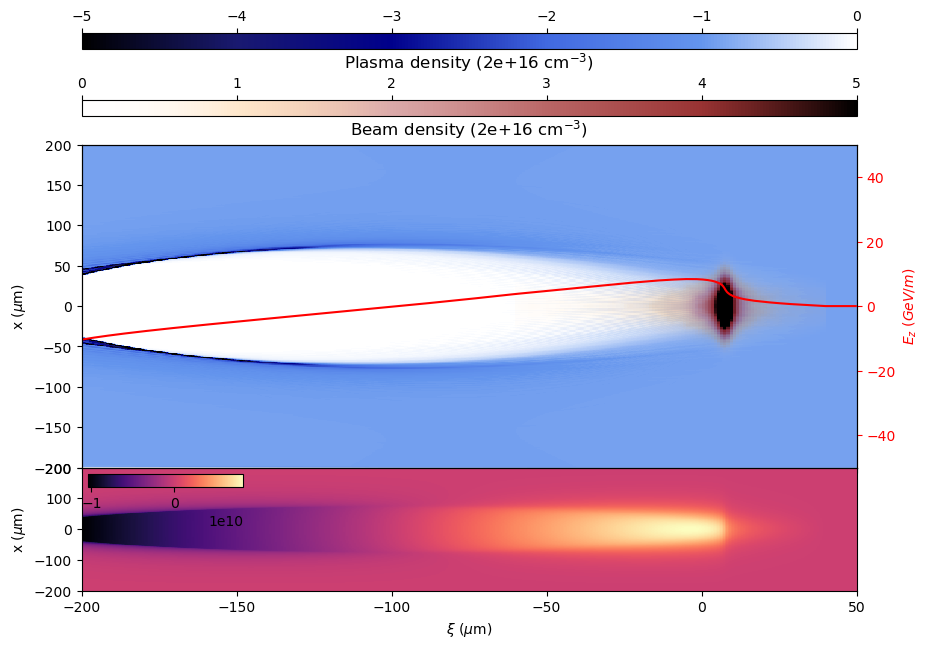

In [12]:
######### plot particles in fields
do_y_bin = True # if true, plot every particle; if false, only plot particle near y = 0
do_number_density_particle = True # whether or not to display number density as a 2D histogram

##### plot settings
fig,(ax1,ax2) = plt.subplots(2,1,sharex = True,figsize = (10,8),gridspec_kw={'height_ratios': [2, 0.5]})
plt.subplots_adjust(wspace=0, hspace=0)
ax2.set_xlabel(r'$\xi$ ($\mu$m)')
ax1.set_ylabel(r'x ($\mu$m)')
ax2.set_ylabel(r'x ($\mu$m)')
ax_E_plot = ax1.twinx()

##### plot plasma density

field_cmap = colors.LinearSegmentedColormap.from_list("", ["Black","midnightblue","darkblue","royalblue","cornflowerblue","white"])

grid_range_z = fcns.cu(info_Ez.z) # in um
grid_range_x = fcns.cu(info_Ez.x) # in um

rho_plot = ax1.pcolormesh(grid_range_z, grid_range_x, np.transpose(rho),cmap = field_cmap, vmax = 0, vmin = -5)
if do_number_density_particle:
    cb_field = plt.colorbar(rho_plot, location='top', aspect=50, pad=0.01)
else:
    cb_field = plt.colorbar(rho_plot, location='top', aspect=50, pad=0.07)
cb_field.set_label(f'Plasma density ({n0}'+r" cm$^{-3}$)",labelpad=-42, y=0.45,fontsize = 12)
#cb_field.set_ticks([0, -1, -2, -3, -4, -5])

##### plot electron bunch
cmap = colors.LinearSegmentedColormap.from_list("", ["white","darkorange","brown","darkred","maroon","black"])
# cmap = anothercmap
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.linspace(0,1,cmap.N)
# create a new colormap
beam_cmap = ListedColormap(my_cmap)

if not do_y_bin:
    select_particles = (y<.5*info_Ez.dx) & (y>-.5*info_Ez.dx) # select particles within the grid near y = 0
    z_in_cell = z[select_particles]
    x_in_cell = x[select_particles]
    ax1.scatter(fcns.cu(z_in_cell),fcns.cu(x_in_cell),s = 0.02,c = 'grey',alpha = 0.5)
elif do_number_density_particle:
    Z, zedges, xedges= np.histogram2d(z, x, bins=[100,100])
    
    for _1 in range(len(zedges)-1):
        for _2 in range(len(xedges)-1):
            if Z[_1][_2] <= 30:
                Z[_1][_2] = 0
                continue
            z_lo = zedges[_1]
            z_hi = zedges[_1+1]
            x_lo = xedges[_2]
            x_hi = xedges[_2+1]
            dz = np.abs(z_lo - z_hi)
            dx = np.abs(x_lo - x_hi)
            dy = 3*np.std(y[(x < x_hi)&(x >= x_lo)&(z >= z_lo)&(z < z_hi)])
            grid_volume = dx*dy*dz # in m^3
            if grid_volume == 0:
                Z[_1][_2] = 0
            else:
                Z[_1][_2] = Z[_1][_2]/len(z) * tot_charge * 6.25e18/(grid_volume*1e6) /n0
            
    Z = ndimage.gaussian_filter(Z, sigma=1, order=0)
    driver = ax1.pcolormesh(zedges*1e6, xedges*1e6, Z.T, cmap= beam_cmap, vmin = 0, vmax = 5)
    cb_driver = plt.colorbar(driver, location='top', aspect=50, pad=0.07)
    cb_driver.set_label(f'Beam density ({n0}'+r" cm$^{-3}$)", labelpad=-42, y=0.45,fontsize = 12)
else:
    Z, zedges, xedges= np.histogram2d(z, x, bins=[100,100])
    Z = ndimage.gaussian_filter(Z, sigma=1, order=0)
    driver = ax1.pcolormesh(zedges*1e6, xedges*1e6, Z.T, cmap= beam_cmap, vmin = 0)    

##### plot central Ez field
#Ez_center = ts.get_field(field='Ez', iteration=iteration, slice_across='x')[0]
Ez_center = Ez.T[int(np.rint(len(Ez)/2))]
Ez_center = Ez_center/10**9

ax_E_plot.plot(grid_range_z,Ez_center, c='r')

ax_E_plot.yaxis.label.set_color('red')
ax_E_plot.set(ylabel=r"$E_z$ $(GeV/m)$")
ax_E_plot.tick_params(axis='y', colors='r')

# put zero in the middle of the axis
Ez_abs_max = abs(max(ax_E_plot.get_ylim(), key=abs))
ax_E_plot.set_ylim(ymin=-50, ymax=50)

##### plot E field in ax2
E_field_plot = ax2.pcolormesh(grid_range_z, grid_range_x, np.transpose(Ez),cmap = 'magma')

cbaxes = inset_axes(ax2, width="20%", height="10%", loc=2) 
cb_E = plt.colorbar(E_field_plot,cax=cbaxes, orientation='horizontal')

print(f"distance traveled: {ts.t[fcns.find_index(ts,iteration)]*3*10**8*10**6}")
#plt.tight_layout()
#plt.savefig('/Users/mengshutang/Desktop/'+data+f'_{iteration}.png',dpi = 300)

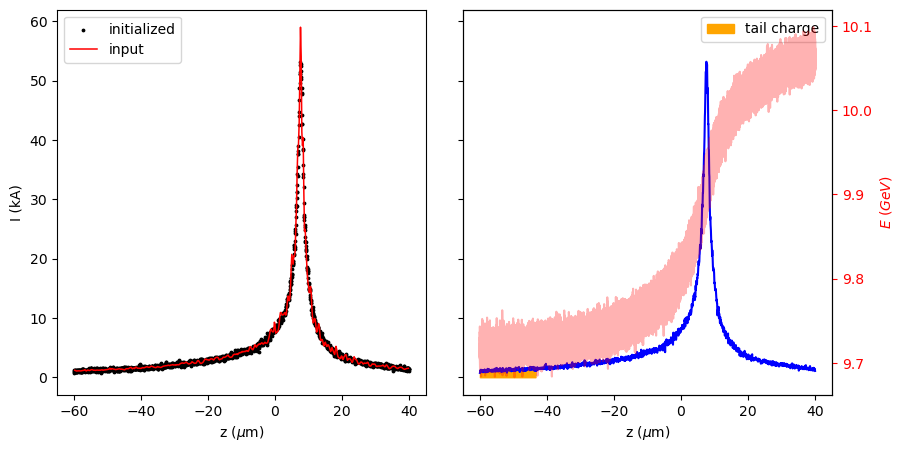

In [6]:
### plot longitudinal beam pdf
hist, bin_edges = np.histogram(z,bins = 2000)

z_edge1 = (bin_edges[:-1] + bin_edges[1:])/2

# convert num of particles in hist bins into current
Clight = 3e8
# Current profile in kA
hist_charge = hist/np.trapz(hist,z_edge1)*tot_charge 
z_I_edge = (z_edge1[:-1] + z_edge1[1:])/2
hist_I_init = (hist_charge[:-1]+hist_charge[1:]) * Clight/2000

fig,axes = plt.subplots(1,2,figsize = (10,5),sharex = True,sharey = True)
plt.subplots_adjust(wspace=0.1)
axes[0].set_xlabel(r"z ($\mu$m)")
axes[1].set_xlabel(r"z ($\mu$m)")
axes[0].set_ylabel("I (kA)")
axes[1].yaxis.tick_right()

### axis 1 plot initialization vs input beam profile
axes[0].scatter(z_I_edge*1e6,hist_I_init, c = 'k',s = 3,label = 'initialized')

### plot input beam profile
if current_profile == 8:
    I_profile = pd.read_csv('/Users/Mengshutang/Desktop/CU_PWFA/COMPUTATIONS/HiPACE/analysis/Tailored_beam_profile/I_profile_8.csv')
elif current_profile == 16:
    I_profile = pd.read_csv('/Users/Mengshutang/Desktop/CU_PWFA/COMPUTATIONS/HiPACE/analysis/Tailored_beam_profile/I_profile_16.csv')
elif current_profile == 4:
     I_profile = pd.read_csv('/Users/Mengshutang/Desktop/CU_PWFA/COMPUTATIONS/HiPACE/analysis/Tailored_beam_profile/I_profile_4.csv')
elif current_profile == 6:
    I_profile = pd.read_csv('/Users/Mengshutang/Desktop/CU_PWFACOMPUTATIONS/HiPACE/analysis/Tailored_beam_profile/I_profile_6.csv')

axes[0].plot(I_profile['z'],I_profile['I'],linewidth = 1.1, c = 'r', label = 'input')
axes[0].legend(loc = 'upper left')

### axis 2 plot percent of the trailing beam
axes[1].plot(z_I_edge*1e6,hist_I_init,c = 'b')

idx = fcns.percent_charge_loc(tail_charge1,tot_charge,hist_I_init,z_I_edge)
axes[1].fill_between(z_I_edge[:idx]*1e6, hist_I_init[:idx], color='orange', alpha=1,label = 'tail charge')
axes[1].legend()

### plot correlated energy spread
def linear_E_chirp(xrange,mean_E,del_E):
    b = mean_E
    k = del_E/np.abs(xrange[0]-xrange[-1])
    return k*xrange + b
    
E_chirp_plot = axes[1].twinx()
#E_chirp_plot.plot(xrange*1e6,linear_E_chirp(xrange*1e6,10,1), c='r')
E_chirp_plot.plot(z*1e6,fcns.P_to_E(pz),c='r',alpha = 0.3)

E_chirp_plot.yaxis.label.set_color('red')
E_chirp_plot.set(ylabel=r"$E$ $(GeV)$")
E_chirp_plot.tick_params(axis='y', colors='r')

#plt.savefig('/Users/mengshutang/desktop/initialization.png',dpi = 300)

tail charge position: 70pC >-4.305895057624327e-05; 300pC >-1.3507363003036297e-05
70pC intialization:
twiss a: 1.22 (input: 1.2); b:0.927 (input: 0.93); g:2.685 (input: 2.624)
x_std: 21.968um (input: 21.799); px_std:0.711 (input: 0.717)
emittance: 9.898um (input: 10.0)

300pC intialization:
twiss a: 1.213 (input: 1.2); b:0.927 (input: 0.93); g:2.667 (input: 2.624)
x_std: 21.961um (input: 21.799); px_std:0.709 (input: 0.717)
emittance: 9.907um (input: 10.0)


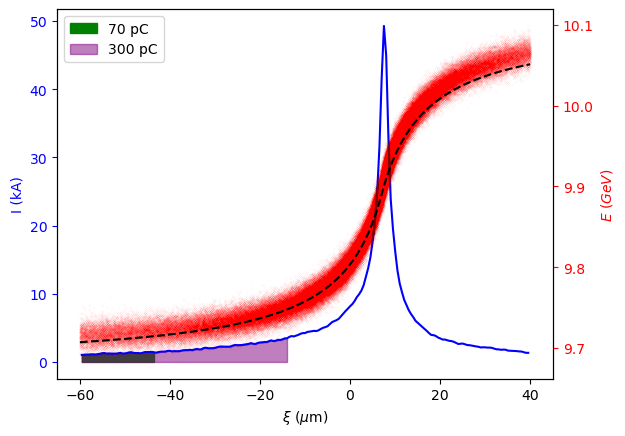

In [7]:
### plot E_chirp
hist, bin_edges = np.histogram(z,bins = 200)

z_edge1 = (bin_edges[:-1] + bin_edges[1:])/2

# convert num of particles in hist bins into current
Clight = 3e8
# Current profile in kA
hist_charge = hist/np.trapz(hist,z_edge1)*tot_charge 
z_I_edge = (z_edge1[:-1] + z_edge1[1:])/2
hist_I_init = (hist_charge[:-1]+hist_charge[1:]) * Clight/2000

fig,axes = plt.subplots(1,1)
#plt.subplots_adjust(wspace=0)
axes.set_xlabel(r"$\xi$ ($\mu$m)")
axes.set_ylabel("I (kA)")
axes.yaxis.label.set_color('b')
axes.tick_params(axis='y', colors='b')

axes.plot(z_I_edge*1e6,hist_I_init,c = 'b')
idx1 = fcns.percent_charge_loc(tail_charge1,tot_charge,hist_I_init,z_I_edge)
axes.fill_between(z_I_edge[:idx1]*1e6, hist_I_init[:idx1], color='g', alpha=1,label = '70 pC')

idx2 = fcns.percent_charge_loc(tail_charge2,tot_charge,hist_I_init,z_I_edge)
axes.fill_between(z_I_edge[:idx2]*1e6, hist_I_init[:idx2], color='purple', alpha=0.5,label = '300 pC')

axes.legend(loc = 'upper left')

### plot correlated energy spread
def linear_E_chirp(xrange,mean_E,del_E):
    b = mean_E
    k = del_E/np.abs(xrange[0]-xrange[-1])
    return k*xrange + b

def sigmoid(z,A,a,z_center):
    z0 = z - z_center
    return C + A*z0/(a+np.abs(z0))

if current_profile == 8:
    A = 0.235
    C = 9.925
    a = 8.5
    z_center = 7
elif current_profile == 16:
    A = 0.21
    C = 9.905
    a = 8
    z_center = 7
elif current_profile == 4:
    A = 0.21
    C = 9.89
    a = 10
    z_center = 7
elif current_profile == 6:
    A = 0.21
    C = 9.91
    a = 5
    z_center = 7

zrange = np.linspace(-60,40,num = 1000)
    
E_chirp_plot = axes.twinx()
E_chirp_plot.scatter(z*1e6,fcns.P_to_E(pz), s = 0.01,c='r',alpha = 0.05)
E_chirp_plot.plot(zrange,sigmoid(zrange,A,a,z_center),linewidth = 1.5, c = 'k',linestyle = '--',label = 'input_E_chirp')
E_chirp_plot.yaxis.label.set_color('red')
E_chirp_plot.set(ylabel=r"$E$ $(GeV)$")
E_chirp_plot.tick_params(axis='y', colors='r')
#E_chirp_plot.legend(loc = 'upper right')
#plt.savefig('/Users/mengshutang/desktop/no_E_chirp.png',dpi = 300)

# initialization of tail charges
x_70,px_70,pz_70 = ts.get_particle(species = beam_name,iteration = 0, select={'z':[-np.inf,z_I_edge[idx1]]},var_list = ['x','ux','uz'])

x_300,px_300,pz_300 = ts.get_particle(species = beam_name,iteration = 0, select={'z':[-np.inf,z_I_edge[idx2]]},var_list = ['x','ux','uz'])

xp_70 = px_70/pz_70
eps_70 = np.sqrt(np.mean(x_70**2) * np.mean(xp_70**2) - np.mean(x_70*xp_70)**2)
a_70 = -np.mean(x_70*xp_70)/eps_70
g_70 = np.std(xp_70)**2/eps_70
b_70 = np.std(x_70)**2/eps_70

xp_300 = px_300/pz_300
eps_300 = np.sqrt(np.mean(x_300**2) * np.mean(xp_300**2) - np.mean(x_300*xp_300)**2)
a_300 = -np.mean(x_300*xp_300)/eps_300
g_300 = np.std(xp_300)**2/eps_300
b_300 = np.std(x_300)**2/eps_300

print(f'tail charge position: 70pC >{z_I_edge[idx1]}; 300pC >{z_I_edge[idx2]}')
print('70pC intialization:')
print(f"twiss a: {np.round(a_70,3)} (input: {a0}); b:{np.round(b_70,3)} (input: {b0}); g:{np.round(g_70,3)} (input: {np.round(g0,3)})")
print(f"x_std: {np.round(np.std(x_70)*1e6,3)}um (input: {np.round(np.sqrt(eps0*b0)*1e6,3)}); px_std:{np.round(np.std(px_70),3)} (input: {np.round(19570*np.sqrt(g0*eps0),3)})")
print(f"emittance: {np.round(np.mean(eps_70*pz_70)*1e6,3)}um (input: {input_emittance*1e6})")
print('')
print('300pC intialization:')
print(f"twiss a: {np.round(a_300,3)} (input: {a0}); b:{np.round(b_300,3)} (input: {b0}); g:{np.round(g_300,3)} (input: {np.round(g0,3)})")
print(f"x_std: {np.round(np.std(x_300)*1e6,3)}um (input: {np.round(np.sqrt(eps0*b0)*1e6,3)}); px_std:{np.round(np.std(px_300),3)} (input: {np.round(19570*np.sqrt(g0*eps0),3)})")
print(f"emittance: {np.round(np.mean(eps_300*pz_300)*1e6,3)}um (input: {input_emittance*1e6})")

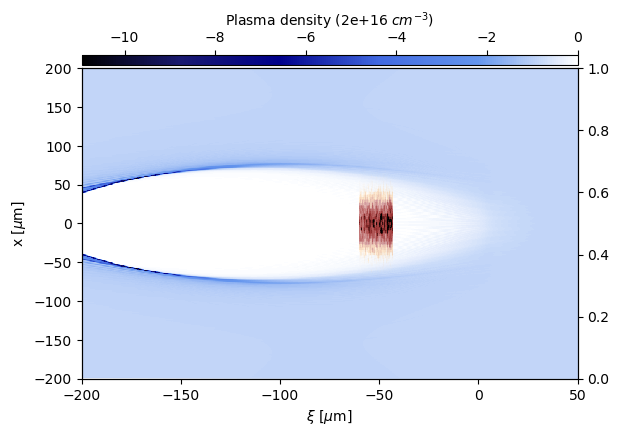

In [8]:
######### plot particles in slices
do_num_slices = False
tail_charge = tail_charge1
##### plot settings
fig,ax1 = plt.subplots(1,1)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.set_xlabel(r'$\xi$ [$\mu$m]')
ax1.set_ylabel(r'x [$\mu$m]')
#ax2.set_ylabel(r'x [$\mu$m]')
ax_E_plot = ax1.twinx()

##### charge density field
field_cmap = colors.LinearSegmentedColormap.from_list("", ["Black","midnightblue","darkblue","royalblue","cornflowerblue","white"])

grid_range_z = fcns.cu(info_Ez.z) # in um
grid_range_x = fcns.cu(info_Ez.x) # in um

rho_plot = ax1.pcolormesh(grid_range_z, grid_range_x, np.transpose(rho),cmap = field_cmap, vmax = 0)
cb_field = plt.colorbar(rho_plot, location='top', aspect=50, pad=0.01,label = f'Plasma density ({n0}'+r" $cm^{-3}$)")

##### driver and witness bunch slices
if do_num_slices:
    num = 4
    driver_info = fcns.plot_particle_info_slices('driver',ts,iteration,num,None,None,None,None)
    
    c_lst = ['green','red','yellow','orange']
    
    for n in range(num):
        x_d = driver_info[n][0]
        z_d = driver_info[n][2]
        print(len(x_d)/len(x))
        ax1.scatter(fcns.cu(z_d),fcns.cu(x_d),s = 0.02,c = c_lst[n])
else:
    head,tail = fcns.plot_particle_info_slices('driver',ts,iteration,None,hist_I_init,z_I_edge,tail_charge,tot_charge)
    #ax1.scatter(fcns.cu(head[2]),fcns.cu(head[0]),s = 0.02,c = 'grey')
    #ax1.scatter(fcns.cu(tail[2]),fcns.cu(tail[0]),s = 0.02,c = 'g',alpha = 0.05)
    Z, xedges, yedges= np.histogram2d(fcns.cu(tail[2]), fcns.cu(tail[0]), bins=[100,100])
    Z = ndimage.gaussian_filter(Z, sigma=1, order=0)
    driver = ax1.pcolormesh(xedges, yedges, Z.T, cmap= beam_cmap,vmax = 20)

    #ax1.axvline(x = -3)
    #ax1.axhline(y = -40)
    #ax1.axhline(y = 40)

#cb2 = plt.colorbar(beam1, ax=ax1, location='top', aspect=50, pad=0.1)
#plt.savefig(f'/Users/mengshutang/Desktop/two_bunch_{iteration}.png',dpi = 300)

-4.443359374999998


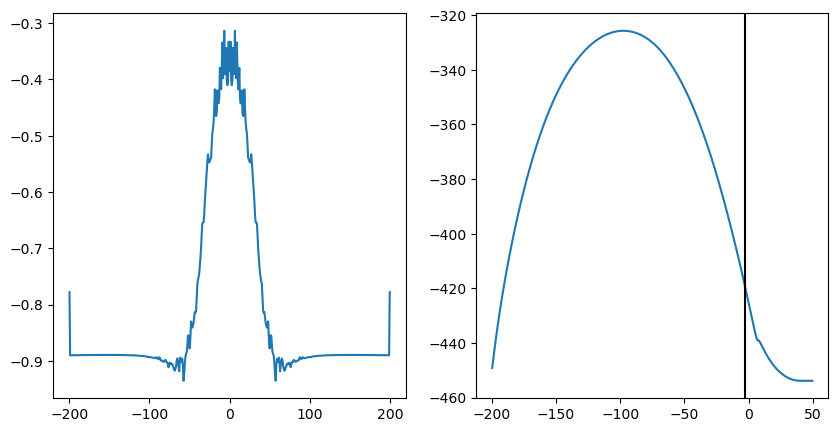

In [9]:
df_rho = pd.DataFrame(rho.T)
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.plot(grid_range_x,df_rho.iloc[:][400])
print(grid_range_z[400])
ax2.plot(grid_range_z,np.sum(rho.T,axis = 0))
ax2.axvline(x = -3, c = 'k')

/var/folders/1_/d86r7cfn7nbb663qcn5ld6qr0000gn/T/ipykernel_97337/823135860.py:26: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for level, line in zip(contour.levels, contour.collections):


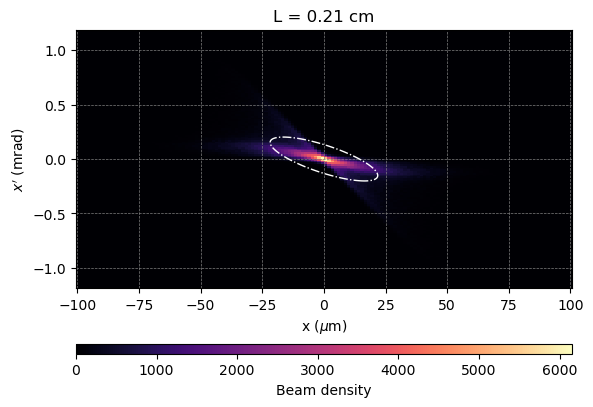

In [10]:
######## plot trace space profile 
## ax1 (top panel) indicates beam density in trace space
## ax2 (bottom panel) displays fractional energy deviation

fig,ax1 = plt.subplots(1,1)
plt.subplots_adjust(wspace=0, hspace=0)

x_prime1 = px/pz * 10**3
x1 = x*10**6
alpha, beta, gamma = fcns.twiss_params(x1,x_prime1)
emit_ts = fcns.ts_emittance_rms(x1,x_prime1)

##### ax1
# beam density histogram
H, xedges, yedges = np.histogram2d(x1, x_prime1, bins=[150,150])

beam = ax1.pcolormesh(xedges, yedges, H.T, cmap='magma')
cb_beam = plt.colorbar(beam, ax=ax1, location='bottom', aspect=50, pad=0.15,label = 'Beam density')

# ellipse in trace space
xrange = np.linspace(xedges[0], xedges[-1], 10**3)
yrange = np.linspace(yedges[0], yedges[-1], 10**3)

X, Y, Z = fcns.plot_params_ts_ellipse(xrange, yrange, emit_ts, alpha, beta, gamma)
contour = ax1.contour(X, Y, Z, levels=[0], colors='white')
for level, line in zip(contour.levels, contour.collections):
    line.set_linestyle('dashdot') 
    line.set_linewidth(1) 
    
ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

#ax1.set_xticks(np.linspace(-10,10,num = 5))
#ax1.set_yticks(np.linspace(-1,1,num = 5))

ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel(r'$x^{\prime}$ (mrad)')

ax1.set_title(f"L = {np.round(ts.t[fcns.find_index(ts,iteration)]*3*10**8*10**2,2)} cm")

del_E = (fcns.P_to_E(pz)-10)/fcns.P_to_E(pz)

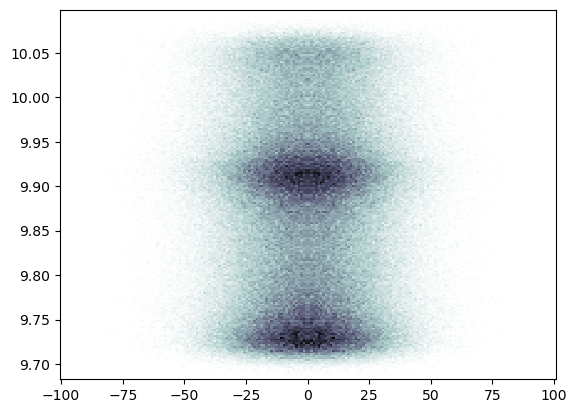

In [11]:
E = fcns.P_to_E(pz)
H, xedges, yedges = np.histogram2d(x, E, bins=[200,200])

beam_f = plt.pcolormesh(xedges*1e6, yedges, H.T, cmap='bone_r')